<a href="https://colab.research.google.com/github/Vkosa/projects_data_science/blob/main/Lisanza_Movie_Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing surprise library, only do it for first time
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633963 sha256=b6e49a20fd9719b922c73dd9dd1f6bace2841d12f7823c2d887886d00171e187
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

In [ ]:
# Import the dataset
#rating = pd.read_csv('ratings.csv')
rating = pd.read_csv('/content/drive/MyDrive/ratings.csv')

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


There are 100004 observations and 4 columns. The columns are numeric data

In [ ]:
# Printing the top 5 rows of the dataset Hint: use .head()

rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


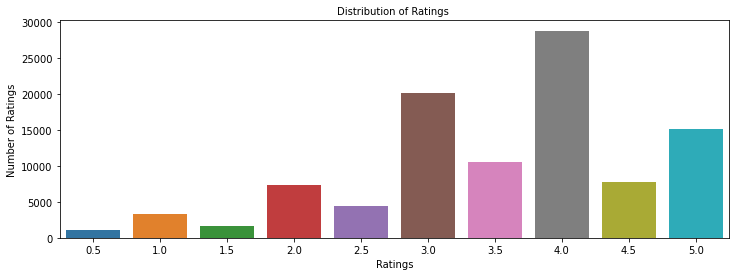

In [ ]:
plt.figure(figsize = (12, 4))

sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

The rating 4.0 has the highest count. 3.0 Is the second and 5.0 is the 3rd highest

In [ ]:
# Finding number of unique users
rating['userId'].nunique()

671

There are 671 users in the dataset

In [ ]:
# Finding number of unique movies

rating['movieId'].nunique()

9066

there are 9066 items

In [ ]:
rating.groupby(['userId', 'movieId']).count()

rating  timestamp
userId movieId                   
1      31            1          1
       1029          1          1
       1061          1          1
       1129          1          1
       1172          1          1
...                ...        ...
671    6268          1          1
       6269          1          1
       6365          1          1
       6385          1          1
       6565          1          1

[100004 rows x 2 columns]

In [ ]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

The sum is equal to the total number of observations. This implies that there is only interaction between a pair of items and a user.

In [ ]:

rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

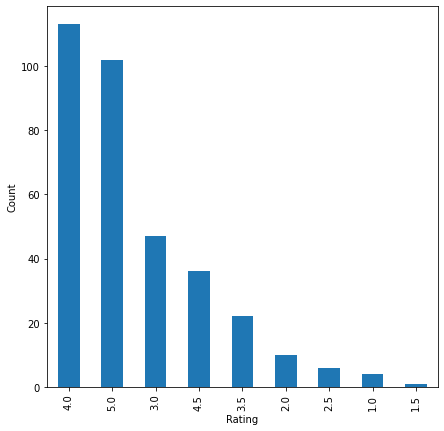

In [ ]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

In [ ]:

rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

The user 547 has interacted with the most number of movies: 2391 times. There still remains a possibility of 6675 interactions: 9066-2391=6675

In [ ]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

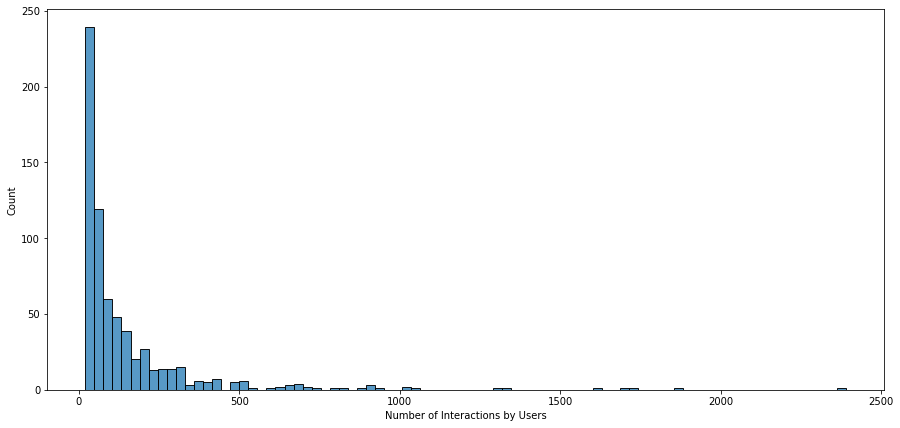

In [ ]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))


sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

The distribution is skewed to the right. A few users interacted with more than 500 items.

In [ ]:

# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [ ]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [ ]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We use this function with different n's and minimum interactions to get movies to recommend

In [ ]:

list(top_n_movies(final_rating, 5, 50))

[858, 318, 969, 913, 1221]

In [ ]:

list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

In [ ]:

list(top_n_movies(final_rating, 5, 200))

[858, 318, 50, 527, 608]

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:


# Defining Nearest neighbour algorithm
sim_options = {'name': 'cosine',
               'user_based': True}
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

Baseline model has RMSE=0.9925 on test set. To improve this number we can use GridSearchCV tuning different hyperparameters of this algorithm

In [ ]:

algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

The user rating is 4.0

In [ ]:

algo_knn_user.predict(4, 10, verbose=True)

user: 4          item: 10         r_ui = None   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=None, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

predicted user rating is 3.62

In [ ]:


# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9652845829878363
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


In [ ]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.964813,0.956782,0.974259,0.965285,0.007143,1,0.740847,0.736305,0.749317,0.742157,0.005392,1,0.196488,0.067507,5.189950,0.520571,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.994513,0.986044,1.002509,0.994355,0.006722,14,0.767832,0.763426,0.775095,0.768784,0.004811,12,0.798617,0.062218,3.196834,0.304354,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.969638,0.959310,0.977141,0.968696,0.007310,3,0.743690,0.738552,0.751821,0.744688,0.005463,2,0.209905,0.008013,3.502073,0.431834,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.997706,0.986969,1.004122,0.996266,0.007076,15,0.769389,0.764243,0.776368,0.770000,0.004969,15,0.671808,0.013065,3.564790,0.388325,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.975973,0.967884,0.981939,0.975265,0.005760,7,0.749101,0.745394,0.756132,0.750209,0.004453,7,0.169461,0.051519,3.235249,0.348922,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


In [ ]:


# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9908


0.9907613369496804

After tuning hyperparameters, RMSE for testset has improved from 0.9925 to 0.9908.

In [ ]:

similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

The baseline and optimized model predicted a rating of 3.62

In [ ]:

similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

The optimized model predicted a rating of 3.20.

In [ ]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[357, 220, 590, 491, 647]

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

In [ ]:

recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

In [ ]:
recommendations

[(98491, 4.832340578646058),
 (116, 4.753206589295344),
 (6669, 4.748048450384675),
 (1221, 4.662571141751736),
 (1192, 4.65824768595177)]

In [ ]:


# Definfing similarity measure
sim_options = {'name': 'cosine','user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

In [ ]:

algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

The predicted rating is 4.37

In [ ]:

algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

the predicted rating is 4.07

In [ ]:


# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9391486933500578
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [ ]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.945440,0.951726,0.950486,0.949217,0.002718,7,0.731824,0.734504,0.732024,0.732784,0.001219,7,6.502673,0.206073,11.909357,0.870559,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.008939,1.012302,1.013359,1.011533,0.001885,16,0.788265,0.790041,0.789338,0.789215,0.000730,16,20.533287,1.347543,11.113672,0.593390,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.945314,0.951867,0.950784,0.949322,0.002868,8,0.731786,0.734679,0.732189,0.732884,0.001280,8,6.263061,0.326779,11.487569,0.412245,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.008794,1.012681,1.013704,1.011727,0.002115,17,0.788214,0.790342,0.789537,0.789364,0.000878,17,19.246025,1.029256,11.296682,0.421407,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.944977,0.952487,0.952065,0.949843,0.003445,9,0.731686,0.735143,0.733102,0.733310,0.001419,9,5.982726,0.352540,11.720712,0.513802,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


In [ ]:

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9465


0.9465120620317036

the RMSE value is 0.9465

In [ ]:
# Remove _______ and complete the code
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.30   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.298279280483517, details={'actual_k': 30, 'was_impossible': False})

the predicted rating is 4.3

In [ ]:

similarity_algo_optimized_item.predict(4, 10, verbose=True)

user: 4          item: 10         r_ui = None   est = 4.30   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=None, est=4.298279280483517, details={'actual_k': 30, 'was_impossible': False})

the predicted rating is 4.30.

In [ ]:

similarity_algo_optimized_item.get_neighbors(4, k=5)

[77, 85, 115, 119, 127]

In [ ]:

recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

In [ ]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3515, 5), (4521, 5)]

In [ ]:

# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9036


0.9035801166303886

The baseline RMSE for matrix factorization model on testset 0.9004 is lower compared to the RMSE for baseline similarity. This is based on the recommendation system 1.0032 and it is less than the RMSE for optimized similarity based recommendation system 0.9908.

In [ ]:

algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.00   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.995423457334701, details={'was_impossible': False})

The rating is 4.09. However, the actual rating is 4.00, there is still some overestimating that we have to fix

In [ ]:

algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.98   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.9807315908427547, details={'was_impossible': False})

the estimated rating is 3.98

In [ ]:


# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8957033853483737
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [ ]:


# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=20, lr_all=.01, reg_all=.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8968


0.8967661647051486

In [ ]:

svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.00   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9951600136078183, details={'was_impossible': False})

In [ ]:

svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.64   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.639466121942824, details={'was_impossible': False})

In [ ]:

get_recommendations(rating, 4, 5, svd_algo_optimized)

[(926, 4.9222293704593305),
 (1192, 4.904960523340165),
 (1948, 4.865192619639084),
 (1217, 4.865154612109177),
 (3035, 4.853017083805296)]

In [ ]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

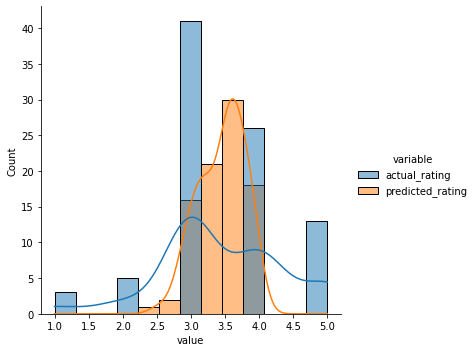

In [ ]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

The distribution of the predicted closely follows the actual ratings.

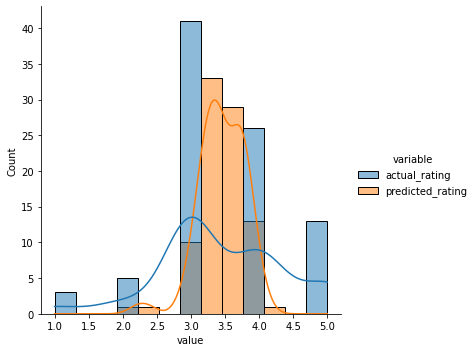

In [ ]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.764
-----> Recall:  0.41
> k=5, model=KNNBasic
-----> Precision:  0.772
-----> Recall:  0.421
> k=5, model=KNNBasic
-----> Precision:  0.613
-----> Recall:  0.331
> k=5, model=KNNBasic
-----> Precision:  0.679
-----> Recall:  0.358
> k=5, model=SVD
-----> Precision:  0.752
-----> Recall:  0.383
> k=5, model=SVD
-----> Precision:  0.746
-----> Recall:  0.384
> k=10, model=KNNBasic
-----> Precision:  0.745
-----> Recall:  0.547
> k=10, model=KNNBasic
-----> Precision:  0.747
-----> Recall:  0.56
> k=10, model=KNNBasic
-----> Precision:  0.594
-----> Recall:  0.474
> k=10, model=KNNBasic
-----> Precision:  0.661
-----> Recall:  0.503
> k=10, model=SVD
-----> Precision:  0.732
-----> Recall:  0.514
> k=10, model=SVD
-----> Precision:  0.731
-----> Recall:  0.521


User-based and Item-based Collaborative Models were nearly same. User based RMSE had a value of .992 while the "Item based" model's RMSE is 1.003. Showing that tuned Collaborative Filtering Models have performed better than the baseline models and the user-user base tuned model performed better with an rmse of 0.9908

The Collaborative Models performed so well because they find similarities from the user-item-ratings data.

Matrix factorization decomposes the user-item matrix into two lower dimensionality rectangular matrices. On the other hand, collaborative filtering searches for neighbors based on similarities and recommends items based on those interactions.

RMSE for Matrix Factorization (0.90) is better than the Collaborative Filtering Models (~1.00).

So tuning did not improve the base line enough because matrix factorization assumes that items and users are present and recommend items based on proximity.